# **DEEP LEARNING PROJECT**
**IMAGE CAPTIONING**

KELOMPOK 9:
1. Kent Amadeo Timotheus - 2702227025
2. Theodore Zachary - 2702244100
3. Renaldo - 2702235670

DATASET: Flickr30k Dataset for image captioning.

LINK KAGGLE : https://www.kaggle.com/datasets/adityajn105/flickr30k



# **IMPORT LIBRARIES & SETUP**

In [ ]:
import os
import math
import pickle
import re
from textwrap import wrap
from tqdm import tqdm
from collections import Counter, defaultdict
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import keras # Added for Keras 3 serialization
import kagglehub
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import Sequence, to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Input, Dense, Embedding, LSTM, Bidirectional,
                                     Dropout, Concatenate, Layer, LayerNormalization,
                                     GlobalAveragePooling2D, Add)
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.applications import EfficientNetV2B0
from tensorflow.keras.applications.efficientnet_v2 import preprocess_input as effnetv2_preprocess
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from nltk.translate.meteor_score import meteor_score

In [ ]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [ ]:
# ==================== GOOGLE DRIVE CONNECTION ====================
try: # if you deny the permission, use colab storage
    from google.colab import drive
    drive.mount('/content/drive')
    DRIVE_PATH = '/content/drive/MyDrive/ImageCaptioning'
    os.makedirs(DRIVE_PATH, exist_ok=True)
    print(f"✓ Google Drive mounted at {DRIVE_PATH}")
    USE_DRIVE = True
except:
    DRIVE_PATH = '.'
    USE_DRIVE = False
    print("⚠ Running without Google Drive")

# ==================== DATASET SETUP ====================
path = kagglehub.dataset_download("adityajn105/flickr30k")
print("Dataset path:", path)
IMAGES_DIR = os.path.join(path, "Images")
CAPTION_FILE = os.path.join(path, "captions.txt")
print(f"Images dir exists: {os.path.exists(IMAGES_DIR)}")
print(f"Captions file exists: {os.path.exists(CAPTION_FILE)}")

# ==================== DATA LOADING ====================
import pandas as pd

def load_flickr8k_captions(filepath):
    image_ids = []
    captions = []
    with open(filepath, 'r') as f:
        for line in f:
            line = line.strip()
            if len(line) < 10 or line.lower().startswith("image"):
                continue
            if "\t" in line:
                img_id, caption = line.split("\t", 1)
            elif "," in line:
                img_id, caption = line.split(",", 1)
            else:
                parts = line.split(" ", 1)
                if len(parts) != 2:
                    continue
                img_id, caption = parts
            img_id = img_id.split("#")[0].strip()
            if not img_id.endswith(".jpg"):
                continue
            image_ids.append(img_id)
            captions.append(caption.strip())
    df = pd.DataFrame({"image": image_ids, "caption": captions})
    return df

data = load_flickr8k_captions(CAPTION_FILE)
print(f"Total captions loaded: {len(data)}")

⚠ Running without Google Drive
Using Colab cache for faster access to the 'flickr30k' dataset.
Dataset path: /kaggle/input/flickr30k
Images dir exists: True
Captions file exists: True
Total captions loaded: 158915


In [ ]:
# ==================== IMAGE PROCESSING ====================
img_size = 224  # EfficientNetV2B0 optimal size

def readImage(path, image_size=img_size):
    img = load_img(path, target_size=(image_size, image_size))
    img = img_to_array(img)
    img = effnetv2_preprocess(img)
    return img

def display_images(temp_df, image_path, image_size=img_size):
    temp_df = temp_df.reset_index(drop=True)
    plt.figure(figsize=(15, 15))
    n = 0
    for i in range(min(len(temp_df), 15)):
        n += 1
        plt.subplot(5, 5, n)
        plt.subplots_adjust(hspace=0.7, wspace=0.3)
        image = readImage(os.path.join(image_path, temp_df['image'][i]), image_size=image_size)
        img_disp = (image - image.min()) / (image.max() - image.min() + 1e-8)
        plt.imshow(img_disp.astype(np.float32))
        plt.title("\n".join(wrap(temp_df['caption'][i], 25)))
        plt.axis('off')
    plt.show()

# ==================== TEXT PREPROCESSING (IMPROVED) ====================
def text_preprocessing(df, caption_col='caption'):
    df[caption_col] = df[caption_col].astype(str).str.strip()
    df[caption_col] = df[caption_col].str.lower()
    # Remove multiple spaces
    df[caption_col] = df[caption_col].apply(lambda x: re.sub(r'\s+', ' ', x))
    # Keep only alphanumeric and basic punctuation
    df[caption_col] = df[caption_col].apply(
        lambda x: re.sub(r"[^a-z0-9\s]", "", x)
    )
    # Add start and end tokens
    df[caption_col] = df[caption_col].apply(
        lambda x: "startseq " + x.strip() + " endseq"
    )
    return df

data = text_preprocessing(data)
captions = data['caption'].tolist()

# ==================== TOKENIZATION (IMPROVED) ====================
# Filter out rare words to reduce vocab size
word_counts = Counter()
for caption in captions:
    word_counts.update(caption.split())

# Keep words that appear at least 5 times
min_word_freq = 5
filtered_captions = []
for caption in captions:
    words = caption.split()
    filtered = [w if word_counts[w] >= min_word_freq else '<unk>' for w in words]
    filtered_captions.append(' '.join(filtered))

tokenizer = Tokenizer(oov_token="<unk>")
tokenizer.fit_on_texts(filtered_captions)
vocab_size = len(tokenizer.word_index) + 1
print(f"Vocabulary size: {vocab_size}")

max_length = max(len(c.split()) for c in captions)
print(f"Max caption length: {max_length}")

# Update data with filtered captions
data['caption'] = filtered_captions

Vocabulary size: 7728
Max caption length: 80


In [ ]:
# ==================== TRAIN/VAL SPLIT ====================
images = data['image'].unique().tolist() # to prevent data leaking, use the images as a base for the split
nimages = len(images)
print(f"Number of unique images: {nimages}")

split_index = round(nimages * 0.85)
train_images = images[:split_index]
val_images = images[split_index:]

train = data[data['image'].isin(train_images)].reset_index(drop=True) # splitted images based on the unique images, taken with each caption it has (5)
val = data[data['image'].isin(val_images)].reset_index(drop=True)

print(f"Train captions: {len(train)}, Val captions: {len(val)}")

# Save tokenizer
tokenizer_path = os.path.join(DRIVE_PATH if USE_DRIVE else '.', 'tokenizer.pkl')
with open(tokenizer_path, 'wb') as f:
    pickle.dump(tokenizer, f)
print(f"✓ Tokenizer saved to {tokenizer_path}")

Number of unique images: 31783
Train captions: 135080, Val captions: 23835
✓ Tokenizer saved to ./tokenizer.pkl


In [ ]:
# ==================== FEATURE EXTRACTION (EfficientNetV2B0) ====================
feature_dir = os.path.join(DRIVE_PATH if USE_DRIVE else '.', 'image_features_effnetv2b0')

# The 'features' dictionary will now store paths to individual .npy files
# instead of the full feature arrays in memory.
features = {}

# Check if feature directory exists and is populated
if os.path.exists(feature_dir) and os.listdir(feature_dir):
    print(f"Loading feature paths from {feature_dir}...")
    for f_name in tqdm(os.listdir(feature_dir), desc="Collecting feature paths"):
        if f_name.endswith('.npy'):
            image_id = f_name.replace('.npy', '')
            features[image_id] = os.path.join(feature_dir, f_name)
    print(f"✓ Loaded {len(features)} feature paths.")
else:
    print(f"Feature directory not found or empty at {feature_dir}. Extracting features...")
    os.makedirs(feature_dir, exist_ok=True)

    base_model = EfficientNetV2B0(
        weights='imagenet',
        include_top=False,
        input_shape=(img_size, img_size, 3),
        pooling=None
    )
    fe_model = Model(inputs=base_model.input, outputs=base_model.output)

    for image_id in tqdm(data['image'].unique(), desc="Extracting features and saving to disk"):
        img_path = os.path.join(IMAGES_DIR, image_id)
        if not os.path.exists(img_path):
            continue

        img = readImage(img_path, image_size=img_size)
        img = np.expand_dims(img, axis=0)
        feat_map = fe_model.predict(img, verbose=0)[0]

        # Save each feature to a separate .npy file
        feature_filename = os.path.join(feature_dir, f"{image_id.replace('.jpg', '')}.npy")
        np.save(feature_filename, feat_map.reshape(-1, feat_map.shape[-1]).astype(np.float32))

        # Store the path to the feature in the dictionary
        features[image_id] = feature_filename
    print(f"✓ Features extracted and saved to {feature_dir}")

# To get sample_feature and num_patches, feat_dim, we load one sample dynamically
if features:
    sample_image_id = next(iter(features.keys()))
    sample_feature_path = features[sample_image_id]
    sample_feature_array = np.load(sample_feature_path)
    num_patches, feat_dim = sample_feature_array.shape
    print(f"Feature shape: ({num_patches}, {feat_dim})")
else:
    print("No features available. Please check dataset or feature extraction process.")
    num_patches = None # Or set a default/raise an error
    feat_dim = None

Feature directory not found or empty at ./image_features_effnetv2b0. Extracting features...
24274472/24274472 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Extracting features and saving to disk: 100%|██████████| 31783/31783 [47:14<00:00, 11.21it/s]

✓ Features extracted and saved to ./image_features_effnetv2b0
Feature shape: (49, 1280)


In [ ]:
# ==================== DATA GENERATOR ====================
class CustomDataGenerator(Sequence):
    def __init__(self, df, X_col, y_col, batch_size, tokenizer,
                 vocab_size, max_length, features_dict, shuffle=True):
        super().__init__()
        self.df = df.copy()
        self.X_col = X_col
        self.y_col = y_col
        self.batch_size = batch_size
        self.tokenizer = tokenizer
        self.vocab_size = vocab_size
        self.max_length = max_length
        self.feature_paths = features_dict # Now stores paths, not arrays
        self.shuffle = shuffle
        self.n = len(self.df)
        if self.shuffle:
            self.df = self.df.sample(frac=1).reset_index(drop=True)

    def on_epoch_end(self):
        if self.shuffle:
            self.df = self.df.sample(frac=1).reset_index(drop=True)

    def __len__(self):
        return int(np.ceil(self.n / float(self.batch_size)))

    def __getitem__(self, index):
        batch = self.df.iloc[index * self.batch_size:(index + 1) * self.batch_size, :]
        X1, X2, y = self.__get_data(batch)
        return (X1, X2), y

    def __get_data(self, batch):
        X1, X2, y = [], [], []
        for _, row in batch.iterrows():
            image_id = row[self.X_col]
            caption = row[self.y_col]

            # Load feature from disk only when needed
            if image_id not in self.feature_paths:
                continue

            # Image IDs in `features` are '1000092795.jpg', remove .jpg for file name
            feature_path = self.feature_paths.get(image_id)
            if feature_path is None or not os.path.exists(feature_path):
                continue # Skip if feature file doesn't exist
            feature = np.load(feature_path)

            seq = self.tokenizer.texts_to_sequences([caption])[0]
            for i in range(1, len(seq)):
                in_seq = seq[:i]
                out_seq = seq[i]
                in_seq = pad_sequences([in_seq], maxlen=self.max_length, padding='post')[0]
                X1.append(feature)
                X2.append(in_seq)
                y.append(out_seq)

        X1 = np.array(X1, dtype=np.float32)
        X2 = np.array(X2, dtype=np.int32)
        y = np.array(y, dtype=np.int32)
        return X1, X2, y

In [ ]:
# ==================== IMPROVED ATTENTION MECHANISM ====================
@tf.keras.utils.register_keras_serializable()
class BahdanauAttention(tf.keras.layers.Layer):
    def __init__(self, units, **kwargs):
        super().__init__(**kwargs)
        self.units = units

    def build(self, input_shape):
        self.W1 = Dense(self.units, use_bias=False)
        self.W2 = Dense(self.units, use_bias=False)
        self.V = Dense(1, use_bias=False)
        super().build(input_shape)

    def call(self, inputs):
        encoder_features, decoder_hidden = inputs
        decoder_hidden = tf.expand_dims(decoder_hidden, 1)
        score = tf.nn.tanh(self.W1(encoder_features) + self.W2(decoder_hidden))
        attention_weights = tf.nn.softmax(self.V(score), axis=1)
        context_vector = tf.reduce_sum(attention_weights * encoder_features, axis=1)
        return context_vector, tf.squeeze(attention_weights, -1)

    def get_config(self):
        config = super().get_config()
        config.update({
            "units": self.units,
        })
        return config


In [ ]:
# ==================== MODEL ARCHITECTURE (IMPROVED) ====================
print("\n Building improved model...")

encoder_input = Input(shape=(num_patches, feat_dim), name='image_features')
decoder_input = Input(shape=(max_length,), name='decoder_input')

# Embedding with higher dimension
embedding_dim = 512
embed = Embedding(
    input_dim=vocab_size,
    output_dim=embedding_dim,
    mask_zero=True,
    name='embed'
)(decoder_input)

# Apply dropout to embedding (Increased from 0.3 to 0.4)
embed = Dropout(0.5)(embed)

# Single LSTM layer with more units (more efficient than BiLSTM for this task)
lstm_out = LSTM(
    512,
    return_sequences=False,
    dropout=0.5, # Increased from 0.3 to 0.4
    recurrent_dropout=0.4, # Increased from 0.2 to 0.3
    kernel_regularizer=tf.keras.regularizers.l2(5e-4), # Added L2 regularization
    name='lstm'
)(embed)

# Layer normalization for stability
lstm_out = LayerNormalization()(lstm_out)

# Attention mechanism
attention_units = 512
attention = BahdanauAttention(attention_units)
context_vector, att_weights = attention([encoder_input, lstm_out])

# Concatenate context + decoder hidden
concat = Concatenate(axis=-1)([context_vector, lstm_out])

# Dense layers with residual-like connection
x = Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(5e-4))(concat) # Added L2 regularization
x = Dropout(0.6)(x) # Increased from 0.4 to 0.5
x = LayerNormalization()(x)

x = Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(5e-4))(x) # Added L2 regularization
x = Dropout(0.5)(x) # Increased from 0.3 to 0.4

# Output layer
outputs = Dense(vocab_size, activation='softmax')(x)

caption_model = Model(inputs=[encoder_input, decoder_input], outputs=outputs)

# Compile with improved optimizer settings
caption_model.compile(
    optimizer=tf.keras.optimizers.Adam(
        learning_rate=3e-4,  # Slightly higher initial LR
        clipnorm=1.0  # Lower clipnorm for better gradient flow
    ),
    loss='sparse_categorical_crossentropy',
    metrics=['sparse_categorical_accuracy']
)

caption_model.summary()


 Building improved model...


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ decoder_input       │ (None, 80)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embed (Embedding)   │ (None, 80, 512)   │  3,956,736 │ decoder_input[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 80, 512)   │          0 │ embed[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal           │ (None, 80)        │          0 │ decoder_input[0]… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ (None, 512)       │  2,099,200 │ dropout[0][0],    │
│                     │                   │            │ not_equal[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ image_features      │ (None, 49, 1280)  │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 512)       │      1,024 │ lstm[0][0]        │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bahdanau_attention  │ [(None, 1280),    │    918,016 │ image_features[0… │
│ (BahdanauAttention) │ (None, 49)]       │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 1792)      │          0 │ bahdanau_attenti… │
│ (Concatenate)       │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 512)       │    918,016 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 512)       │          0 │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 512)       │      1,024 │ dropout_1[0][0]   │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 256)       │    131,328 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 256)       │          0 │ dense_4[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 7728)      │  1,986,096 │ dropout_2[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 10,011,440 (38.19 MB)

 Trainable params: 10,011,440 (38.19 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
class HistoryLogger(tf.keras.callbacks.Callback): # to record history and save it every epoch
    def __init__(self, filepath, interval=1):
        super().__init__()
        self.filepath = filepath
        self.interval = interval # save every "interval" epochs
        self.history_data = {}

    def on_epoch_end(self, epoch, logs=None):
        for k, v in logs.items():
            self.history_data.setdefault(k, []).append(v)

        if (epoch + 1) % self.interval == 0 or (epoch + 1) == self.params['epochs']: # save history data at the specified interval or at the last epoch
            with open(self.filepath, 'wb') as f:
                pickle.dump(self.history_data, f)
            print(f'\n✓ Training history saved to {self.filepath} after epoch {epoch + 1}')


In [ ]:
import gc

# ==================== TRAINING ====================
# Clear Keras session and collect garbage to free up memory
tf.keras.backend.clear_session()
gc.collect()

batch_size = 64  # Reduced batch size to prevent OOM errors

train_generator = CustomDataGenerator(
    df=train, X_col='image', y_col='caption',
    batch_size=batch_size, tokenizer=tokenizer,
    vocab_size=vocab_size, max_length=max_length,
    features_dict=features, shuffle=True
)

validation_generator = CustomDataGenerator(
    df=val, X_col='image', y_col='caption',
    batch_size=batch_size, tokenizer=tokenizer,
    vocab_size=vocab_size, max_length=max_length,
    features_dict=features, shuffle=False
)

model_path = os.path.join(DRIVE_PATH if USE_DRIVE else '.', 'caption_model_effnetv2b0.keras')
history_path = os.path.join(DRIVE_PATH if USE_DRIVE else '.', 'training_history.pkl')

initial_epoch = 0
# Load model if it exists to resume training
if os.path.exists(model_path):
    print(f"Loading model from {model_path} to resume training...")
    # Pass custom objects explicitly to load_model
    caption_model = tf.keras.models.load_model(model_path, custom_objects={'BahdanauAttention': BahdanauAttention})
    if os.path.exists(history_path):
        with open(history_path, 'rb') as f:
            loaded_history_data = pickle.load(f)
        # Determine initial_epoch from loaded history
        if 'loss' in loaded_history_data and loaded_history_data['loss']:
            initial_epoch = len(loaded_history_data['loss'])
            print(f"Resuming training from epoch {initial_epoch}...")
    else:
        print("No previous history found, starting new history.")
else:
    print("No existing model found, starting training from scratch.")

checkpoint = ModelCheckpoint(
    model_path,
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    verbose=1
)

earlystopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    verbose=1,
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    patience=2,
    factor=0.5,
    min_lr=1e-7,
    verbose=1
)

history_logger = HistoryLogger(filepath=history_path, interval=1)
# If history was loaded, set it to the history_logger
if 'loaded_history_data' in locals():
    history_logger.history_data = loaded_history_data

print("\n🚀 Starting training...")
history = caption_model.fit(
    train_generator,
    epochs=20,
    initial_epoch=initial_epoch,
    validation_data=validation_generator,
    callbacks=[checkpoint, earlystopping, reduce_lr, history_logger],
    verbose=1
)

No existing model found, starting training from scratch.

🚀 Starting training...
Epoch 1/20
2111/2111 ━━━━━━━━━━━━━━━━━━━━ 0s 695ms/step - loss: 5.2867 - sparse_categorical_accuracy: 0.2320
Epoch 1: val_loss improved from inf to 4.82682, saving model to ./caption_model_effnetv2b0.keras

✓ Training history saved to ./training_history.pkl after epoch 1
2111/2111 ━━━━━━━━━━━━━━━━━━━━ 1609s 757ms/step - loss: 5.2864 - sparse_categorical_accuracy: 0.2320 - val_loss: 4.8268 - val_sparse_categorical_accuracy: 0.2951 - learning_rate: 3.0000e-04
Epoch 2/20
2111/2111 ━━━━━━━━━━━━━━━━━━━━ 0s 706ms/step - loss: 3.9422 - sparse_categorical_accuracy: 0.3170
Epoch 2: val_loss improved from 4.82682 to 4.44770, saving model to ./caption_model_effnetv2b0.keras

✓ Training history saved to ./training_history.pkl after epoch 2
2111/2111 ━━━━━━━━━━━━━━━━━━━━ 1623s 769ms/step - loss: 3.9422 - sparse_categorical_accuracy: 0.3170 - val_loss: 4.4477 - val_sparse_categorical_accuracy: 0.3139 - learning_rate: 3.

In [ ]:
# Load model if already exist (skip training)
print("\nLoading model for direct evaluation...")

model_path = os.path.join(DRIVE_PATH if USE_DRIVE else '.', 'caption_model_effnetv2b0.keras')
history_path = os.path.join(DRIVE_PATH if USE_DRIVE else '.', 'training_history.pkl')
# metrics_path = os.path.join(DRIVE_PATH if USE_DRIVE else '.', 'evaluation_metrics.pkl')

if os.path.exists(model_path):
    try:
        caption_model = tf.keras.models.load_model(
            model_path,
            custom_objects={'BahdanauAttention': BahdanauAttention},
            compile=False # No need to compile if just evaluating
        )
        print(f"✓ Successfully loaded model from {model_path}")

    except Exception as e:
        print(f"Error loading or evaluating model: {e}")
        print("Please ensure all necessary dependencies and custom objects are defined.")
else:
    print(f"Model file not found at {model_path}. Please train the model first or check the path.")



Loading model for direct evaluation...
✓ Successfully loaded model from ./caption_model_effnetv2b0.keras


✓ Loaded training history from ./training_history.pkl


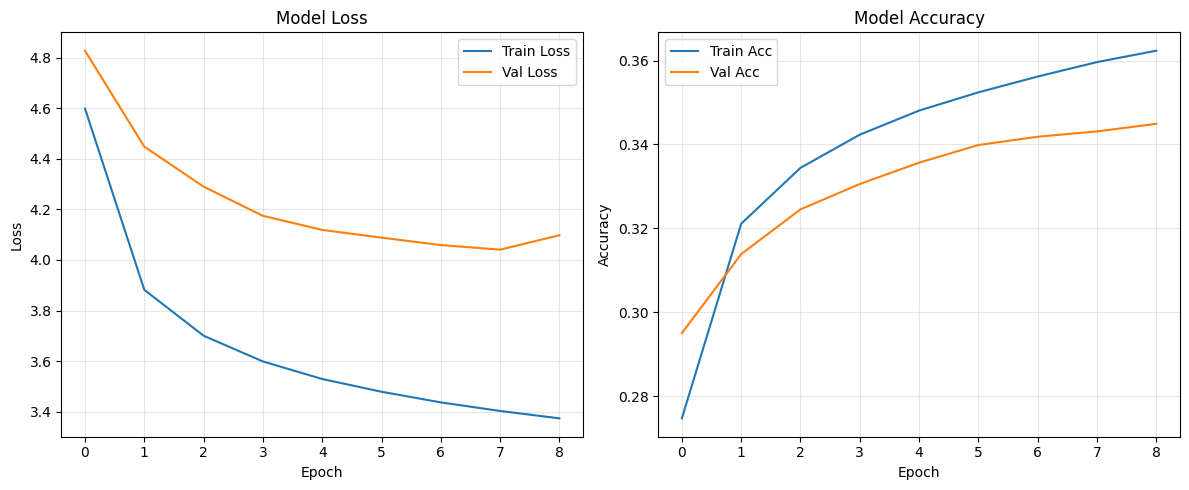

✓ Plot saved to ./training_plot.png


In [ ]:
# ==================== PLOT TRAINING HISTORY ====================
# Load history if it's not already available (e.g., after kernel restart or resumed training)
if 'history' not in locals() and os.path.exists(history_path):
    with open(history_path, 'rb') as f:
        loaded_history_data = pickle.load(f)
    # Create a dummy history object to hold the loaded data for plotting
    class DummyHistory:
        def __init__(self, history_data):
            self.history = history_data
    history = DummyHistory(loaded_history_data)
    print(f"✓ Loaded training history from {history_path}")
elif 'history' not in locals():
    print("Warning: Training history not found. Please train the model first or check history_path.")

if 'history' in locals() and history.history:
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.subplot(1, 2, 2)
    plt.plot(history.history['sparse_categorical_accuracy'], label='Train Acc')
    plt.plot(history.history['val_sparse_categorical_accuracy'], label='Val Acc')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plot_path = os.path.join(DRIVE_PATH if USE_DRIVE else '.', 'training_plot.png')
    plt.savefig(plot_path, dpi=150, bbox_inches='tight')
    plt.show()
    print(f"✓ Plot saved to {plot_path}")
else:
    print("No history available to plot.")


In [ ]:
# ==================== PREDICTION FUNCTIONS ====================
def idx_to_word(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

def clean_caption(raw_caption):
    caption = raw_caption.replace('startseq', '').replace('endseq', '').strip()
    caption = caption.capitalize()
    if caption and not caption.endswith('.'):
        caption = caption + '.'
    return caption

def beam_search_predictions(model, tokenizer, feature_array, max_length, beam_index=5):
    start_token = tokenizer.word_index.get('startseq')
    end_token = tokenizer.word_index.get('endseq')

    if start_token is None or end_token is None:
        raise ValueError("startseq/endseq tokens missing in tokenizer")

    sequences = [[[start_token], 0.0]]

    for _ in range(max_length):
        all_candidates = []
        for seq, score in sequences:
            if seq[-1] == end_token:
                all_candidates.append((seq, score))
                continue

            sequence = pad_sequences([seq], maxlen=max_length, padding='post')
            # Pass the already loaded feature_array directly
            yhat = model.predict([feature_array[np.newaxis, ...], sequence], verbose=0)[0]

            # Get top-k predictions
            top_indices = np.argsort(yhat)[-beam_index:]
            for idx in top_indices:
                prob = yhat[idx]
                if prob <= 1e-6:
                    continue
                candidate_seq = seq + [int(idx)]
                candidate_score = score - np.log(prob + 1e-10)
                all_candidates.append((candidate_seq, candidate_score))

        ordered = sorted(all_candidates, key=lambda tup: tup[1])
        sequences = ordered[:beam_index]

        if all(s[-1] == end_token for s, _ in sequences):
            break

    best_seq = sequences[0][0]
    words = [idx_to_word(i, tokenizer) for i in best_seq]
    caption = " ".join([w for w in words if w is not None])
    return clean_caption(caption)

def predict_caption_beam(model, image_id, tokenizer, max_length,
                        feature_paths_dict, beam_index=5):
    # Load feature from disk for prediction
    feature_path = feature_paths_dict.get(image_id)
    if feature_path is None or not os.path.exists(feature_path):
        print(f"Warning: Feature file not found for image {image_id}. Skipping prediction.")
        return ""
    feature_array = np.load(feature_path)
    return beam_search_predictions(model, tokenizer, feature_array, max_length, beam_index)

In [ ]:
# ==================== EVALUATION METRICS ====================
def lcs_length(x, y):
    m, n = len(x), len(y)
    dp = [[0] * (n + 1) for _ in range(m + 1)]
    for i in range(m):
        for j in range(n):
            if x[i] == y[j]:
                dp[i + 1][j + 1] = dp[i][j] + 1
            else:
                dp[i + 1][j + 1] = max(dp[i][j + 1], dp[i + 1][j])
    return dp[m][n]

def rouge_l_score(reference_tokens_list, hypothesis_tokens):
    best_f = 0.0
    for ref in reference_tokens_list:
        lcs = lcs_length(ref, hypothesis_tokens)
        if lcs == 0:
            continue
        prec = lcs / len(hypothesis_tokens) if len(hypothesis_tokens) > 0 else 0
        rec = lcs / len(ref) if len(ref) > 0 else 0
        if prec + rec == 0:
            f = 0.0
        else:
            f = (2 * prec * rec) / (prec + rec)
        best_f = max(best_f, f)
    return best_f

def build_idf(references_per_image):
    df = Counter()
    N = len(references_per_image)
    for refs in references_per_image.values():
        words = set()
        for r in refs:
            words.update(r)
        for w in words:
            df[w] += 1
    idf = {}
    for w, c in df.items():
        idf[w] = math.log((N + 1) / (c + 1)) + 1.0
    return idf

def cider_like_score(ref_tokens_list, hyp_tokens, idf):
    tf_ref = Counter()
    tf_hyp = Counter(hyp_tokens)
    for ref in ref_tokens_list:
        tf_ref.update(ref)

    ref_vec = {w: tf * idf.get(w, 0.0) for w, tf in tf_ref.items()}
    hyp_vec = {w: tf * idf.get(w, 0.0) for w, tf in tf_hyp.items()}

    common = set(ref_vec.keys()) & set(hyp_vec.keys())
    dot = sum(ref_vec[w] * hyp_vec[w] for w in common)

    ref_norm = math.sqrt(sum(v * v for v in ref_vec.values()))
    hyp_norm = math.sqrt(sum(v * v for v in hyp_vec.values()))

    if ref_norm == 0 or hyp_norm == 0:
        return 0.0
    return dot / (ref_norm * hyp_norm)

def build_references(df):
    refs = defaultdict(list)
    for _, row in df.iterrows():
        img = row['image']
        cap = row['caption']
        cap = cap.replace('startseq', '').replace('endseq', '').strip()
        tokens = cap.lower().split()
        refs[img].append(tokens)
    return refs

def evaluate_caption_model(model, tokenizer, feature_paths_dict, val_df,
                          max_length, beam_index=5):
    references_per_image = build_references(val_df)
    idf = build_idf(references_per_image)
    smoothie = SmoothingFunction().method4

    bleu4_scores = []
    meteor_scores = []
    cider_scores = []

    all_images = list(references_per_image.keys())

    for img_id in tqdm(all_images, desc="Evaluating"):
        if img_id not in feature_paths_dict:
            continue

        hyp_caption = predict_caption_beam(
            model, img_id, tokenizer, max_length,
            feature_paths_dict, beam_index=beam_index
        )
        hyp_tokens = hyp_caption.lower().replace('.', '').split()
        ref_tokens_list = references_per_image[img_id]

        bleu4 = sentence_bleu(ref_tokens_list, hyp_tokens,
                             weights=(0.25, 0.25, 0.25, 0.25), smoothing_function=smoothie)

        meteors = [meteor_score([r], hyp_tokens) for r in ref_tokens_list]
        meteor_val = max(meteors) if meteors else 0.0

        cider_val = cider_like_score(ref_tokens_list, hyp_tokens, idf)

        bleu4_scores.append(bleu4)
        meteor_scores.append(meteor_val)
        cider_scores.append(cider_val)

    print("\n" + "="*50)
    print("📊 EVALUATION RESULTS (Validation Set)")
    print("="*50)
    print(f"BLEU-4 : {np.mean(bleu4_scores):.4f}")
    print(f"METEOR : {np.mean(meteor_scores):.4f}")
    print(f"CIDEr* : {np.mean(cider_scores):.4f}")
    print("="*50)

    return {
        'bleu4': np.mean(bleu4_scores),
        'meteor': np.mean(meteor_scores),
        'cider_like': np.mean(cider_scores)
    }

# ==================== RUN EVALUATION ====================
print("\n🔍 Evaluating model...")

# --- Evaluation optimization ---
# 1. Evaluate on a smaller subset of the validation data (uncomment and adjust frac for a quick test)
val_to_evaluate = val.sample(frac=0.06, random_state=42).reset_index(drop=True)
print(f"Evaluating on a subset of {len(val_to_evaluate)} validation captions.")

# 2. Reduce the 'beam_index' parameter for faster, but potentially less accurate, predictions
#    (e.g., beam_index=3 instead of 5)

# Use the full validation set by default, or the subset if uncommented above
val_to_evaluate = locals().get('val_to_evaluate', val)
current_beam_index = 5 # default, change here to experiment with smaller values

metrics = evaluate_caption_model(
    caption_model, tokenizer, features, # features now contains paths
    val_to_evaluate, max_length=max_length, beam_index=current_beam_index
)

# Save metrics
metrics_path = os.path.join(DRIVE_PATH if USE_DRIVE else '.', 'evaluation_metrics.pkl')
with open(metrics_path, 'wb') as f:
    pickle.dump(metrics, f)
print(f"✓ Metrics saved to {metrics_path}")


🔍 Evaluating model...
Evaluating on a subset of 1430 validation captions.


Evaluating: 100%|██████████| 1276/1276 [3:19:37<00:00,  9.39s/it]


📊 EVALUATION RESULTS (Validation Set)
BLEU-4 : 0.0505
METEOR : 0.1857
CIDEr* : 0.1632
✓ Metrics saved to ./evaluation_metrics.pkl



📷 Generating sample predictions...


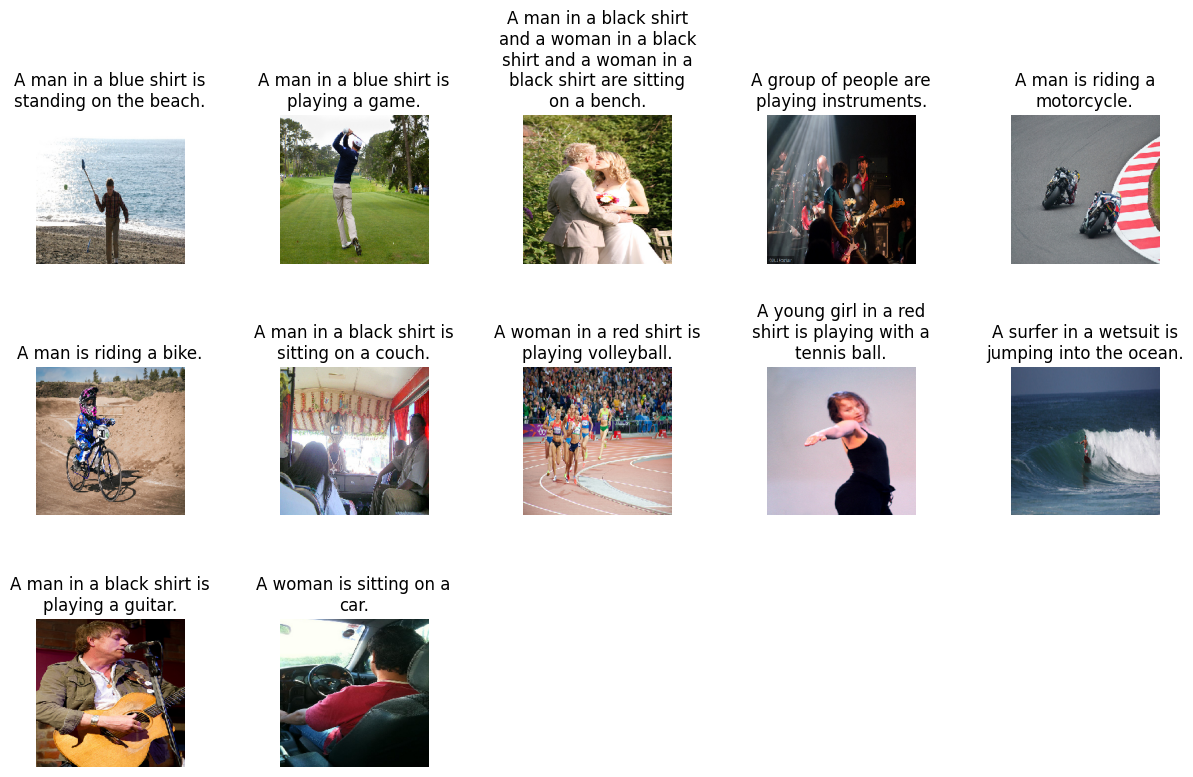

In [ ]:
# ==================== VISUALIZE PREDICTIONS ====================
print("\n📷 Generating sample predictions...")
samples = val.sample(min(12, len(val))).reset_index(drop=True)
samples['pred_caption'] = ""

for idx, row in samples.iterrows():
    if row['image'] not in features:
        continue
    pred = predict_caption_beam(
        caption_model, row['image'], tokenizer,
        max_length, features, beam_index=5
    )
    samples.at[idx, 'pred_caption'] = pred

samples_disp = samples.copy()
samples_disp['caption'] = samples_disp['pred_caption']
display_images(samples_disp, IMAGES_DIR, image_size=img_size)

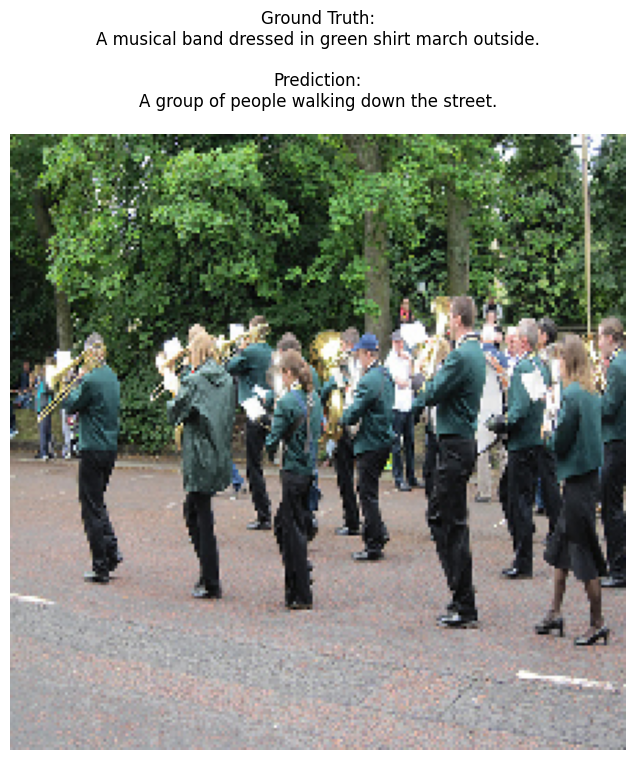

✓ Sample comparison saved to ./sample_comparison.png


In [ ]:
# ==================== SINGLE IMAGE COMPARISON ====================
sample = val.sample(1).iloc[0]
if sample['image'] in features:
    pred_caption = predict_caption_beam(
        caption_model, sample['image'], tokenizer,
        max_length, features, beam_index=5
    )
    true_caption = clean_caption(sample['caption'])

    img_path = os.path.join(IMAGES_DIR, sample['image'])
    img = load_img(img_path, target_size=(img_size, img_size))

    plt.figure(figsize=(8, 8))
    plt.imshow(img)
    plt.axis("off")
    plt.title(f"Ground Truth:\n{true_caption}\n\nPrediction:\n{pred_caption}",
              fontsize=12, pad=20)

    comparison_path = os.path.join(DRIVE_PATH if USE_DRIVE else '.', 'sample_comparison.png')
    plt.savefig(comparison_path, dpi=150, bbox_inches='tight')
    plt.show()
    print(f"✓ Sample comparison saved to {comparison_path}")

In [ ]:
print("\n✅ Training and evaluation complete!")
if USE_DRIVE:
    print(f"📁 All files saved to Google Drive: {DRIVE_PATH}")


✅ Training and evaluation complete!
